In [1]:
import keras
import tensorflow as tf
import glob
from pathlib import Path
from astropy.io import fits
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
import time
from sklearn.metrics import f1_score, matthews_corrcoef
from keras import optimizers

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.1.0


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.is_built_with_cuda()

True

# DFNN

In [7]:
galaxy = np.zeros(1600)
for filepath in glob.iglob('../Data/galaxyfits/*fits', recursive=True):
    fp = Path(filepath)
    hdulist = fits.open(fp)
    scidata = hdulist[0].data
    scidata = scidata.flatten()
    galaxy = np.vstack((galaxy,scidata.transpose()))
galaxy = galaxy[1:,]
print(galaxy.shape)

(829, 1600)


In [8]:
galaxy = np.zeros(1600)
for filepath in glob.iglob('../Data/cutouts/galaxyfits/*fits', recursive=True):
    fp = Path(filepath)
    hdulist = fits.open(fp)
    scidata = hdulist[0].data
    scidata = scidata.flatten()
    galaxy = np.vstack((galaxy,scidata.transpose()))
galaxy = galaxy[1:,]
print(galaxy.shape)
ones = np.ones((len(galaxy),1))
galaxy = np.hstack((galaxy,ones))
print(galaxy)
star = np.zeros(1600)
count = 0
for filepath in glob.iglob('../Data/cutouts/starfits/*fits', recursive=True):
    fp = Path(filepath)
    hdulist = fits.open(fp)
    scidata = hdulist[0].data
    scidata = scidata.flatten()
    star = np.vstack((star,scidata.transpose()))
    count += 1
    if count == len(galaxy):
        break
star = star[1:,]
print(star.shape)
zeros = np.zeros((len(star),1))
star = np.hstack((star,zeros))
print(star)
df = pd.DataFrame(np.vstack((galaxy,star)))
X = df.drop([1600],axis=1)
y = df[1600]
print(X,y)
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X)
transformer
transformer.transform(X)
X = pd.DataFrame(transformer.transform(X))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from keras import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(256, activation='relu', kernel_initializer='random_normal', input_dim=1600, ))
classifier.add(Dropout(0.5))
#Second  Hidden Layer
classifier.add(Dense(64, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dropout(0.5))
#Third  Hidden Layer
classifier.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dropout(0.5))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#Compiling the neural network
classifier.compile(optimizer =optimizers.Adam(amsgrad=True),loss='binary_crossentropy', metrics =['accuracy'])
#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=32, epochs=1024, shuffle=True, use_multiprocessing=True)
classifier.summary()
eval_model=classifier.evaluate(X_train, y_train)
eval_model
y_pred=classifier.predict(X_test)
y_pred =(y_pred>0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
matt = matthews_corrcoef(y_test, y_pred)
print(cm)
print('F1'+'{:.3%}'.format(f1))
print("Error Rate:"+'{:.3%}'.format((cm[0,1]+cm[1,0])/np.sum(cm)))
print("Accuracy:"+'{:.3%}'.format((cm[0,0]+cm[1,1])/np.sum(cm)))
print("Sensitivity:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[0,:])))
print("Specificity :"+'{:.3%}'.format((cm[1,1])/np.sum(cm[1,:])))
print("Precision:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[:,0])))
print("False Positive Rate:"+'{:.3%}'.format(1-((cm[1,1])/np.sum(cm[1,:]))))
print("Matthews Correlation Coefficient:"+'{:.3%}'.format(matt))
print("F1 Score:"+'{:.3%}'.format(f1))


(3123, 1600)
[[ 26.60893512  60.82042313  30.41021156 ...  60.82042313 -19.00638223
    1.        ]
 [ 64.62169957  22.80765867 -11.40382934 ...  -7.60255289 -38.01276445
    1.        ]
 [ 48.78079796 115.3000679  -88.69235992 ... -53.21541595 -31.04232597
    1.        ]
 ...
 [  0.          69.7310257    8.71637821 ... -17.43275642  47.94008017
    1.        ]
 [  4.35818911  52.29826927  39.22370195 ... -30.50732374 -43.58189106
    1.        ]
 [ 21.79094553  47.94008017  78.44740391 ...  21.79094553 -61.01464748
    1.        ]]


KeyboardInterrupt: 

# CNN

In [5]:
tic = time.perf_counter()
galaxy = np.zeros((40,40))
for filepath in glob.iglob('../Data/npycutouts/galaxyfits/*npy', recursive=True):
    fp = Path(filepath)
    array = np.load(fp)
    galaxy = np.dstack((galaxy,array))
galaxy = galaxy[:,:,1:]
print(galaxy.shape[2])
toc = time.perf_counter()
print(f"Runtime {toc - tic} seconds")

3123
Runtime 22.5233582 seconds


In [6]:
from scipy.ndimage import rotate
galaxy = np.dstack((galaxy, np.rot90(galaxy,1),np.rot90(galaxy,2),np.rot90(galaxy,3)))
galaxy = np.dstack((galaxy,np.flip(galaxy,axis=0)))
print(len(galaxy))

40


In [7]:
print(galaxy.shape)

(40, 40, 24984)


In [12]:
'''
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
    '''

'\ndatagen = ImageDataGenerator(\n    featurewise_center=True,\n    featurewise_std_normalization=True,\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    horizontal_flip=True)\n    '

In [8]:
tic = time.perf_counter()
star = np.zeros((40,40))
count = 0
for filepath in glob.iglob('../Data/npycutouts/starfits/*npy', recursive=True):
    fp = Path(filepath)
    array = np.load(fp)
    star = np.dstack((star,array))
    count += 1
    if count == galaxy.shape[2]:
        break
star = star[:,:,1:]
print(star.shape)
toc = time.perf_counter()
print(f"Runtime {toc - tic} seconds")

(40, 40, 24984)
Runtime 1368.7706295 seconds


In [9]:
X = np.dstack((galaxy,star))
y = np.dstack((np.ones((1,1,galaxy.shape[2])),np.zeros((1,1,star.shape[2]))))
print(X.shape)

(40, 40, 49968)


In [10]:
X = np.moveaxis(X, -1, 0)
y = np.moveaxis(y, -1, 0)

In [11]:
print(y.shape)

(49968, 1, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [14]:
X_train = X_train.reshape(len(X_train),40,40,1)
X_test = X_test.reshape(len(X_test),40,40,1)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(16, kernel_size=5, activation='relu', input_shape=(40,40,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='random_normal'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#Compiling the neural network
model.compile(optimizer =optimizers.Adam(amsgrad=True),loss='binary_crossentropy', metrics =['accuracy'])
#Fitting the data to the training dataset
history = model.fit(X_train,y_train, batch_size=32, epochs=1024, shuffle=True, use_multiprocessing=True)

Epoch 1/1024
39974/39974 [==============================] - 7s 170us/step - loss: 6.3548 - accuracy: 0.7272
Epoch 2/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.5553 - accuracy: 0.7912
Epoch 3/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.4811 - accuracy: 0.8152
Epoch 4/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.4310 - accuracy: 0.8299
Epoch 5/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.4112 - accuracy: 0.8411
Epoch 6/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.3842 - accuracy: 0.8513
Epoch 7/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.3610 - accuracy: 0.8587
Epoch 8/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.3439 - accuracy: 0.8655
Epoch 9/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.3320 - accuracy: 0.8721
Epoch 10/1024
39974/39974 [=========

39974/39974 [==============================] - 4s 94us/step - loss: 0.1601 - accuracy: 0.9413
Epoch 77/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1633 - accuracy: 0.9407
Epoch 78/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1580 - accuracy: 0.9425
Epoch 79/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1584 - accuracy: 0.9421
Epoch 80/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1553 - accuracy: 0.9429
Epoch 81/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1585 - accuracy: 0.9421
Epoch 82/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1569 - accuracy: 0.9416
Epoch 83/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1565 - accuracy: 0.9425
Epoch 84/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1557 - accuracy: 0.9423
Epoch 85/1024
39974/39974 [===============

39974/39974 [==============================] - 4s 94us/step - loss: 0.1206 - accuracy: 0.9565
Epoch 152/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1225 - accuracy: 0.9554
Epoch 153/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1227 - accuracy: 0.9551
Epoch 154/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1188 - accuracy: 0.9566
Epoch 155/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1155 - accuracy: 0.9582
Epoch 156/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1159 - accuracy: 0.9580
Epoch 157/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1142 - accuracy: 0.9580
Epoch 158/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1291 - accuracy: 0.9537
Epoch 159/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1218 - accuracy: 0.9565
Epoch 160/1024
39974/39974 [======

39974/39974 [==============================] - 4s 94us/step - loss: 0.0936 - accuracy: 0.9660
Epoch 227/1024
39974/39974 [==============================] - 4s 93us/step - loss: 0.0967 - accuracy: 0.9653
Epoch 228/1024
39974/39974 [==============================] - 4s 93us/step - loss: 0.0969 - accuracy: 0.9650
Epoch 229/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0977 - accuracy: 0.9646
Epoch 230/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1059 - accuracy: 0.9625
Epoch 231/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0953 - accuracy: 0.9659
Epoch 232/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0964 - accuracy: 0.9653
Epoch 233/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0936 - accuracy: 0.9662
Epoch 234/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0919 - accuracy: 0.9670
Epoch 235/1024
39974/39974 [======

39974/39974 [==============================] - 4s 94us/step - loss: 0.0824 - accuracy: 0.9700
Epoch 302/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0843 - accuracy: 0.9696
Epoch 303/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0824 - accuracy: 0.9696
Epoch 304/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0801 - accuracy: 0.9714
Epoch 305/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0801 - accuracy: 0.9705
Epoch 306/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0786 - accuracy: 0.9719
Epoch 307/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0819 - accuracy: 0.9709
Epoch 308/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0823 - accuracy: 0.9703
Epoch 309/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0848 - accuracy: 0.9694
Epoch 310/1024
39974/39974 [======

39974/39974 [==============================] - 4s 95us/step - loss: 0.0742 - accuracy: 0.9735
Epoch 377/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0778 - accuracy: 0.9716
Epoch 378/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0745 - accuracy: 0.9729
Epoch 379/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0728 - accuracy: 0.9738
Epoch 380/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0729 - accuracy: 0.9736
Epoch 381/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1042 - accuracy: 0.9643
Epoch 382/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0796 - accuracy: 0.9711
Epoch 383/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0714 - accuracy: 0.9739
Epoch 384/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0841 - accuracy: 0.9702
Epoch 385/1024
39974/39974 [======

39974/39974 [==============================] - 4s 95us/step - loss: 0.0815 - accuracy: 0.9701
Epoch 452/1024
39974/39974 [==============================] - 4s 96us/step - loss: 0.0765 - accuracy: 0.9725
Epoch 453/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0680 - accuracy: 0.9745
Epoch 454/1024
39974/39974 [==============================] - 4s 96us/step - loss: 0.0659 - accuracy: 0.9759
Epoch 455/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0651 - accuracy: 0.9763
Epoch 456/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0645 - accuracy: 0.9765
Epoch 457/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0653 - accuracy: 0.9760
Epoch 458/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0672 - accuracy: 0.9746
Epoch 459/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0665 - accuracy: 0.9755
Epoch 460/1024
39974/39974 [======

39974/39974 [==============================] - 4s 95us/step - loss: 0.0587 - accuracy: 0.9780
Epoch 527/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0586 - accuracy: 0.9777
Epoch 528/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0581 - accuracy: 0.9783
Epoch 529/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0575 - accuracy: 0.9781
Epoch 530/1024
39974/39974 [==============================] - 4s 96us/step - loss: 0.0560 - accuracy: 0.9796
Epoch 531/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0574 - accuracy: 0.9782
Epoch 532/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0561 - accuracy: 0.9790
Epoch 533/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0562 - accuracy: 0.9796
Epoch 534/1024
39974/39974 [==============================] - 4s 102us/step - loss: 0.0589 - accuracy: 0.9785
Epoch 535/1024
39974/39974 [=====

39974/39974 [==============================] - 4s 96us/step - loss: 0.0561 - accuracy: 0.9792
Epoch 602/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0543 - accuracy: 0.9798
Epoch 603/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0532 - accuracy: 0.9803
Epoch 604/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0515 - accuracy: 0.9808
Epoch 605/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0510 - accuracy: 0.9810
Epoch 606/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0560 - accuracy: 0.9798
Epoch 607/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0561 - accuracy: 0.9792
Epoch 608/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0553 - accuracy: 0.9791
Epoch 609/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0573 - accuracy: 0.9786
Epoch 610/1024
39974/39974 [======

39974/39974 [==============================] - 4s 95us/step - loss: 0.0462 - accuracy: 0.9823
Epoch 676/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0504 - accuracy: 0.9809
Epoch 677/1024
39974/39974 [==============================] - 4s 96us/step - loss: 0.0528 - accuracy: 0.9807
Epoch 678/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0491 - accuracy: 0.9816
Epoch 679/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0486 - accuracy: 0.9815
Epoch 680/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0491 - accuracy: 0.9814
Epoch 681/1024
39974/39974 [==============================] - 4s 96us/step - loss: 0.0540 - accuracy: 0.9801
Epoch 682/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0559 - accuracy: 0.9788
Epoch 683/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0518 - accuracy: 0.9808
Epoch 684/1024
39974/39974 [======

39974/39974 [==============================] - 4s 94us/step - loss: 0.0498 - accuracy: 0.9807
Epoch 751/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0487 - accuracy: 0.9818
Epoch 752/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0479 - accuracy: 0.9819
Epoch 753/1024
39974/39974 [==============================] - 4s 96us/step - loss: 0.0458 - accuracy: 0.9830
Epoch 754/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0456 - accuracy: 0.9831
Epoch 755/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0491 - accuracy: 0.9814
Epoch 756/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0489 - accuracy: 0.9817
Epoch 757/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0483 - accuracy: 0.9815
Epoch 758/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0462 - accuracy: 0.9821
Epoch 759/1024
39974/39974 [======

39974/39974 [==============================] - 4s 94us/step - loss: 0.1666 - accuracy: 0.9376
Epoch 825/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1612 - accuracy: 0.9398
Epoch 826/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1548 - accuracy: 0.9419
Epoch 827/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1495 - accuracy: 0.9446
Epoch 828/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1449 - accuracy: 0.9465
Epoch 829/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1435 - accuracy: 0.9458
Epoch 830/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1417 - accuracy: 0.9472
Epoch 831/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.1373 - accuracy: 0.9490
Epoch 832/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.1361 - accuracy: 0.9508
Epoch 833/1024
39974/39974 [======

39974/39974 [==============================] - 4s 94us/step - loss: 0.0695 - accuracy: 0.9732
Epoch 900/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0672 - accuracy: 0.9748
Epoch 901/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0661 - accuracy: 0.9756
Epoch 902/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0655 - accuracy: 0.9749
Epoch 903/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0682 - accuracy: 0.9746
Epoch 904/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0654 - accuracy: 0.9759
Epoch 905/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0679 - accuracy: 0.9756
Epoch 906/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0637 - accuracy: 0.9768
Epoch 907/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0661 - accuracy: 0.9746
Epoch 908/1024
39974/39974 [======

39974/39974 [==============================] - 4s 94us/step - loss: 0.0543 - accuracy: 0.9788
Epoch 975/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0546 - accuracy: 0.9798
Epoch 976/1024
39974/39974 [==============================] - 4s 97us/step - loss: 0.0545 - accuracy: 0.9783
Epoch 977/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0558 - accuracy: 0.9792
Epoch 978/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0556 - accuracy: 0.9788
Epoch 979/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0540 - accuracy: 0.9791
Epoch 980/1024
39974/39974 [==============================] - 4s 94us/step - loss: 0.0546 - accuracy: 0.9793
Epoch 981/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0503 - accuracy: 0.9810
Epoch 982/1024
39974/39974 [==============================] - 4s 95us/step - loss: 0.0493 - accuracy: 0.9815
Epoch 983/1024
39974/39974 [======

In [17]:
eval_model=model.evaluate(X_train, y_train)
eval_model
y_pred=model.predict(X_test)
y_pred =(y_pred>0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
matt = matthews_corrcoef(y_test, y_pred)
print(cm)
print('F1'+'{:.3%}'.format(f1))
print("Error Rate:"+'{:.3%}'.format((cm[0,1]+cm[1,0])/np.sum(cm)))
print("Accuracy:"+'{:.3%}'.format((cm[0,0]+cm[1,1])/np.sum(cm)))
print("Sensitivity:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[0,:])))
print("Specificity :"+'{:.3%}'.format((cm[1,1])/np.sum(cm[1,:])))
print("Precision:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[:,0])))
print("False Positive Rate:"+'{:.3%}'.format(1-((cm[1,1])/np.sum(cm[1,:]))))
print("Matthews Correlation Coefficient:"+'{:.3%}'.format(matt))
print("F1 Score:"+'{:.3%}'.format(f1))

39974/39974 [==============================] - 2s 41us/step
[[4705  288]
 [ 400 4601]]
F193.043%
Error Rate:6.884%
Accuracy:93.116%
Sensitivity:94.232%
Specificity :92.002%
Precision:92.165%
False Positive Rate:7.998%
Matthews Correlation Coefficient:86.254%
F1 Score:93.043%


In [18]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('../Figures/CNN_Augment_Self.png')
plt.show()

<Figure size 640x480 with 1 Axes>

In [19]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(40,40,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Conv2D(32, kernel_size=5, activation='relu',strides=(2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=5, activation='relu',strides=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='random_normal'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
#Compiling the neural network
model.compile(optimizer =optimizers.Adam(amsgrad=True),loss='binary_crossentropy', metrics =['accuracy'])
#Fitting the data to the training dataset
history = model.fit(X_train,y_train, batch_size=32, epochs=1024, shuffle=True, use_multiprocessing=True)

Epoch 1/1024
39974/39974 [==============================] - 8s 192us/step - loss: 1.5271 - accuracy: 0.7607
Epoch 2/1024
39974/39974 [==============================] - 8s 189us/step - loss: 0.4067 - accuracy: 0.8185
Epoch 3/1024
39974/39974 [==============================] - 7s 185us/step - loss: 0.3727 - accuracy: 0.8376
Epoch 4/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.3557 - accuracy: 0.8497
Epoch 5/1024
39974/39974 [==============================] - 7s 187us/step - loss: 0.3373 - accuracy: 0.8576
Epoch 6/1024
39974/39974 [==============================] - 7s 186us/step - loss: 0.3223 - accuracy: 0.8657
Epoch 7/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.3145 - accuracy: 0.8705
Epoch 8/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.3071 - accuracy: 0.8757
Epoch 9/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.2955 - accuracy: 0.8804
Epoch 10/1024
39974/39974 [=

39974/39974 [==============================] - 7s 172us/step - loss: 0.1428 - accuracy: 0.9503
Epoch 77/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.1401 - accuracy: 0.9508
Epoch 78/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1397 - accuracy: 0.9505
Epoch 79/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1416 - accuracy: 0.9499
Epoch 80/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1378 - accuracy: 0.9524
Epoch 81/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1367 - accuracy: 0.9521
Epoch 82/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1349 - accuracy: 0.9520
Epoch 83/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1378 - accuracy: 0.9512
Epoch 84/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1318 - accuracy: 0.9539
Epoch 85/1024
39974/39974 [======

39974/39974 [==============================] - 7s 172us/step - loss: 0.1025 - accuracy: 0.9633
Epoch 151/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1017 - accuracy: 0.9646
Epoch 152/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1056 - accuracy: 0.9628
Epoch 153/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1023 - accuracy: 0.9649
Epoch 154/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1022 - accuracy: 0.9641
Epoch 155/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.1031 - accuracy: 0.9642
Epoch 156/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0992 - accuracy: 0.9648
Epoch 157/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0986 - accuracy: 0.9657
Epoch 158/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0979 - accuracy: 0.9655
Epoch 159/1024
39974/3997

39974/39974 [==============================] - 7s 172us/step - loss: 0.0802 - accuracy: 0.9708
Epoch 225/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0805 - accuracy: 0.9717
Epoch 226/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0823 - accuracy: 0.9715
Epoch 227/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0821 - accuracy: 0.9707
Epoch 228/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0785 - accuracy: 0.9715
Epoch 229/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0839 - accuracy: 0.9701
Epoch 230/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0824 - accuracy: 0.9701
Epoch 231/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0816 - accuracy: 0.9712
Epoch 232/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0789 - accuracy: 0.9718
Epoch 233/1024
39974/3997

39974/39974 [==============================] - 7s 172us/step - loss: 0.0665 - accuracy: 0.9758
Epoch 299/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0652 - accuracy: 0.9761
Epoch 300/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0663 - accuracy: 0.9757
Epoch 301/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0685 - accuracy: 0.9752
Epoch 302/1024
39974/39974 [==============================] - 7s 170us/step - loss: 0.0681 - accuracy: 0.9744
Epoch 303/1024
39974/39974 [==============================] - 7s 172us/step - loss: 0.0671 - accuracy: 0.9753
Epoch 304/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0651 - accuracy: 0.9764
Epoch 305/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0637 - accuracy: 0.9768
Epoch 306/1024
39974/39974 [==============================] - 7s 171us/step - loss: 0.0657 - accuracy: 0.9765
Epoch 307/1024
39974/3997

39974/39974 [==============================] - 7s 175us/step - loss: 0.0599 - accuracy: 0.9785
Epoch 373/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0605 - accuracy: 0.9770
Epoch 374/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0582 - accuracy: 0.9783
Epoch 375/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0565 - accuracy: 0.9786
Epoch 376/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0596 - accuracy: 0.9789
Epoch 377/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0572 - accuracy: 0.9784
Epoch 378/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0594 - accuracy: 0.9780
Epoch 379/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0545 - accuracy: 0.9798
Epoch 380/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0585 - accuracy: 0.9785
Epoch 381/1024
39974/3997

39974/39974 [==============================] - 7s 174us/step - loss: 0.0507 - accuracy: 0.9814
Epoch 447/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0511 - accuracy: 0.9809
Epoch 448/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0484 - accuracy: 0.9804
Epoch 449/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0519 - accuracy: 0.9807
Epoch 450/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0544 - accuracy: 0.9793
Epoch 451/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0523 - accuracy: 0.9800
Epoch 452/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0518 - accuracy: 0.9805
Epoch 453/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0490 - accuracy: 0.9812
Epoch 454/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0507 - accuracy: 0.9807
Epoch 455/1024
39974/3997

39974/39974 [==============================] - 7s 174us/step - loss: 0.0461 - accuracy: 0.9824
Epoch 521/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0505 - accuracy: 0.9805
Epoch 522/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0489 - accuracy: 0.9813
Epoch 523/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0466 - accuracy: 0.9824
Epoch 524/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0448 - accuracy: 0.9825
Epoch 525/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0457 - accuracy: 0.9821
Epoch 526/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0456 - accuracy: 0.9827
Epoch 527/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0459 - accuracy: 0.9825
Epoch 528/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0500 - accuracy: 0.9815
Epoch 529/1024
39974/3997

39974/39974 [==============================] - 7s 175us/step - loss: 0.0463 - accuracy: 0.9827
Epoch 595/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0426 - accuracy: 0.9833
Epoch 596/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0428 - accuracy: 0.9828
Epoch 597/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0404 - accuracy: 0.9843
Epoch 598/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0410 - accuracy: 0.9835
Epoch 599/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0433 - accuracy: 0.9839
Epoch 600/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0412 - accuracy: 0.9840
Epoch 601/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0426 - accuracy: 0.9833
Epoch 602/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0437 - accuracy: 0.9835
Epoch 603/1024
39974/3997

39974/39974 [==============================] - 7s 174us/step - loss: 0.0389 - accuracy: 0.9848
Epoch 669/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0381 - accuracy: 0.9852
Epoch 670/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0393 - accuracy: 0.9844
Epoch 671/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0385 - accuracy: 0.9842
Epoch 672/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0388 - accuracy: 0.9855
Epoch 673/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0383 - accuracy: 0.9843
Epoch 674/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0375 - accuracy: 0.9848
Epoch 675/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0381 - accuracy: 0.9850
Epoch 676/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0402 - accuracy: 0.9839
Epoch 677/1024
39974/3997

39974/39974 [==============================] - 7s 173us/step - loss: 0.0379 - accuracy: 0.9850
Epoch 743/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0336 - accuracy: 0.9863
Epoch 744/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0380 - accuracy: 0.9849
Epoch 745/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0373 - accuracy: 0.9848
Epoch 746/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0385 - accuracy: 0.9850
Epoch 747/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0356 - accuracy: 0.9855
Epoch 748/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0368 - accuracy: 0.9853
Epoch 749/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0346 - accuracy: 0.9857
Epoch 750/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0381 - accuracy: 0.9853
Epoch 751/1024
39974/3997

39974/39974 [==============================] - 7s 177us/step - loss: 0.0337 - accuracy: 0.9860
Epoch 817/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0334 - accuracy: 0.9861
Epoch 818/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0330 - accuracy: 0.9862
Epoch 819/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0356 - accuracy: 0.9859
Epoch 820/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0336 - accuracy: 0.9870
Epoch 821/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0350 - accuracy: 0.9868
Epoch 822/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0336 - accuracy: 0.9866
Epoch 823/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0348 - accuracy: 0.9856
Epoch 824/1024
39974/39974 [==============================] - 7s 180us/step - loss: 0.0335 - accuracy: 0.9864
Epoch 825/1024
39974/3997

39974/39974 [==============================] - 7s 175us/step - loss: 0.0313 - accuracy: 0.9877
Epoch 891/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0332 - accuracy: 0.9865
Epoch 892/1024
39974/39974 [==============================] - 7s 181us/step - loss: 0.0344 - accuracy: 0.9863
Epoch 893/1024
39974/39974 [==============================] - 8s 201us/step - loss: 0.0326 - accuracy: 0.9866
Epoch 894/1024
39974/39974 [==============================] - 7s 176us/step - loss: 0.0333 - accuracy: 0.9864
Epoch 895/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0339 - accuracy: 0.9864
Epoch 896/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0313 - accuracy: 0.9871
Epoch 897/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0342 - accuracy: 0.9862
Epoch 898/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0310 - accuracy: 0.9872
Epoch 899/1024
39974/3997

39974/39974 [==============================] - 7s 175us/step - loss: 0.0302 - accuracy: 0.9875
Epoch 965/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0321 - accuracy: 0.9871
Epoch 966/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0292 - accuracy: 0.9880
Epoch 967/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0350 - accuracy: 0.9859
Epoch 968/1024
39974/39974 [==============================] - 7s 173us/step - loss: 0.0315 - accuracy: 0.9869
Epoch 969/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0295 - accuracy: 0.9879
Epoch 970/1024
39974/39974 [==============================] - 7s 175us/step - loss: 0.0295 - accuracy: 0.9872
Epoch 971/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0313 - accuracy: 0.9869
Epoch 972/1024
39974/39974 [==============================] - 7s 174us/step - loss: 0.0304 - accuracy: 0.9872
Epoch 973/1024
39974/3997

In [20]:
eval_model=model.evaluate(X_train, y_train)
eval_model
y_pred=model.predict(X_test)
y_pred =(y_pred>0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
matt = matthews_corrcoef(y_test, y_pred)
print(cm)
print('F1'+'{:.3%}'.format(f1))
print("Error Rate:"+'{:.3%}'.format((cm[0,1]+cm[1,0])/np.sum(cm)))
print("Accuracy:"+'{:.3%}'.format((cm[0,0]+cm[1,1])/np.sum(cm)))
print("Sensitivity:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[0,:])))
print("Specificity :"+'{:.3%}'.format((cm[1,1])/np.sum(cm[1,:])))
print("Precision:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[:,0])))
print("False Positive Rate:"+'{:.3%}'.format(1-((cm[1,1])/np.sum(cm[1,:]))))
print("Matthews Correlation Coefficient:"+'{:.3%}'.format(matt))
print("F1 Score:"+'{:.3%}'.format(f1))

39974/39974 [==============================] - 2s 62us/step
[[4797  196]
 [ 411 4590]]
F193.798%
Error Rate:6.074%
Accuracy:93.926%
Sensitivity:96.075%
Specificity :91.782%
Precision:92.108%
False Positive Rate:8.218%
Matthews Correlation Coefficient:87.935%
F1 Score:93.798%


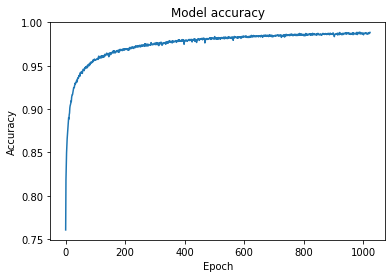

In [21]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('../Figures/CNN_Augment_MNIST.png')
plt.show()

In [19]:
print(history.history)

{'loss': [1.3569059150738279, 0.42428966149610975, 0.3932865221570955, 0.37639109414571664, 0.3523866596150411, 0.3367994757072901, 0.32364883910794323, 0.30924839981680496, 0.29446538898546076, 0.29523310030378075, 0.2789766810349432, 0.2820472923114575, 0.27207972413145054, 0.2666166394385329, 0.26171009380515947, 0.2637414573369105, 0.2662456844885663, 0.26001761454139966, 0.2535205616079807, 0.2620049939733762, 0.25630708995412704, 0.25349282424641795, 0.2529768664021737, 0.2498266767219694, 0.26526551470509024, 0.2732925797729839, 0.24420100400117062, 0.24792279668464343, 0.2732022386419831, 0.24833832988715396, 0.24096741417463244, 0.24156946512196847, 0.24869519680277705, 0.2587937611059363, 0.26750511736126537, 0.24942816900903983, 0.23563979464349324, 0.2668432127224914, 0.2468693182002838, 0.2333991577162054, 0.2966167067803896, 0.25501799527817576, 0.23190362492482397, 0.22318437741279554, 0.2429902915079442, 0.24508023465258855, 0.2657131154017289, 0.251793342926864, 0.2628

In [ ]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('../Figures/CNN_accuracy_augment.png')
plt.show()

In [ ]:
model.summary()

In [32]:
from keras.utils import plot_model
plot_model(model, to_file='../Figure/CNN_model_augment.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [ ]:
eval_model=model.evaluate(X_train, y_train)
eval_model
y_pred=model.predict(X_test)
y_pred =(y_pred>0.5)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [24]:
print(model.predict(X_test))

[[2.5428350e-03]
 [1.0000000e+00]
 [1.9108639e-13]
 ...
 [1.0000000e+00]
 [1.0000000e+00]
 [7.7794360e-10]]


In [29]:
prob = model.predict(X_test).flatten()

In [37]:
import plotly.express as px
fig = px.histogram(x = prob,log_y=True,labels={'x':'Probability'})
fig.write_image("../Figures/probability.png")
fig.show()


In [ ]:
print(cm[0,1])

In [ ]:
def MCC(matrix):
    '''
    Calcualtes the Matthews Correlation Coefficient from a confusion matrix
    '''
    return ((matrix[0,0]*matrix[1,1])-(matrix[1,0]*matrix[0,1]))/np.sqrt((cm[0,0]+cm[1,0])*(cm[0,0]+cm[0,1])*(cm[1,1]+cm[1,0])*(cm[1,1]+cm[0,1]))

In [ ]:
print("Error Rate:"+'{:.3%}'.format((cm[0,1]+cm[1,0])/np.sum(cm)))
print("Accuracy:"+'{:.3%}'.format((cm[0,0]+cm[1,1])/np.sum(cm)))
print("Sensitivity:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[0,:])))
print("Specificity :"+'{:.3%}'.format((cm[1,1])/np.sum(cm[1,:])))
print("Precision:"+'{:.3%}'.format((cm[0,0])/np.sum(cm[:,0])))
print("False Positive Rate:"+'{:.3%}'.format(1-((cm[1,1])/np.sum(cm[1,:]))))
print("Matthews Correlation Coefficient:"+'{:.3%}'.format(MCC(cm)))

In [39]:
model.save('../Models/CNN_model_augment.h5')

## Sanity Check

In [ ]:
for filepath in glob.iglob('../Data/cutouts/starfits/*fits', recursive=True):
    fp = Path(filepath)
    hdulist = fits.open(fp)
    scidata = hdulist[0].data
    

In [179]:
filepath = '../Data/cutouts/starfits/starfits-256.fits'
fp = Path(filepath)
hdulist = fits.open(fp)
scidata = hdulist[0].data

In [181]:
# Stars should return 0, galaxies return 1
model.predict(scidata.reshape(1,40,40,1))

array([[0.36742818]], dtype=float32)

In [30]:
tf.__version__

'2.1.0'

In [28]:
print(X)

[[[ 2.66089351e+01  6.08204231e+01  3.04102116e+01 ...  3.04102116e+01
   -4.56153173e+01  5.32178702e+01]
  [-1.52051058e+01 -3.80127645e+00 -3.80127645e+00 ... -3.80127645e+00
   -1.52051058e+01  7.60255289e+00]
  [ 4.18140409e+01 -2.28076587e+01 -3.80127645e+00 ... -7.60255289e+00
    2.28076587e+01  2.28076587e+01]
  ...
  [ 3.42114880e+01 -2.28076587e+01  7.60255289e+01 ... -2.28076587e+01
    4.94165938e+01  7.60255289e+01]
  [ 5.70191467e+01 -6.84229760e+01  8.36280818e+01 ...  1.14038293e+01
    7.60255289e+00 -2.66089351e+01]
  [-5.70191467e+01  1.14038293e+01 -1.14038293e+01 ...  7.22242525e+01
    6.08204231e+01 -1.90063822e+01]]

 [[ 6.46216996e+01  2.28076587e+01 -1.14038293e+01 ... -4.18140409e+01
    1.14038293e+01 -2.66089351e+01]
  [ 3.04102116e+01  1.52051058e+01 -1.90063822e+01 ... -2.28076587e+01
   -3.80127645e+00 -3.80127645e+01]
  [-3.80127645e+00  3.04102116e+01 -1.52051058e+01 ... -4.18140409e+01
    7.60255289e+01 -2.28076587e+01]
  ...
  [-1.52051058e+01  3.4

# Autokeras

In [1]:
import autokeras as ak

# Initialize the image classifier.
clf = ak.ImageClassifier()
# Feed the image classifier with training data.
clf.fit(X_train, y_train)

# Predict with the best model.
predicted_y = clf.predict(X_test)
print(predicted_y)

# Evaluate the best model with testing data.
print(clf.evaluate(X_test, y_test))

NameError: name 'X_train' is not defined

In [53]:
model = clf.export_model()

## GPU test

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
tf.test.is_built_with_cuda()

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))